This file provides a simple demo of using KMP, where trajectory adaptations towards various desired points in terms of positions and velocities are studied. This code is written by Dr. Yanlong Huang.

### Initializations

In [1]:
myColors;
addpath('../fcts/');

## Load position and velocity from demos

In [2]:
load('../2Dletters/C.mat');
demoNum=5;                    % number of demos
demo_dt=0.01;                 % time interval of data
demoLen=size(demos{1}.pos,2); % size of each demo;
demo_dura=demoLen*demo_dt;    % time length of each demo
dim=2;                        % dimension of demo

totalNum=0;
for i=1:demoNum        
    for j=1:demoLen
        totalNum=totalNum+1;
        Data(1,totalNum)=j*demo_dt;
        Data(2:dim+1,totalNum)=demos{i}.pos(1:dim,j);
        if j<demoLen
            Data(dim+2:2*dim+1,totalNum)=(demos{i}.pos(1:dim,j+1)-demos{i}.pos(1:dim,j))/demo_dt;
        else 
            Data(dim+2:2*dim+1,totalNum)=Data(dim+2:2*dim+1,totalNum-1);
        end
    end    
end

## Extract the reference trajectory

In [3]:
model.nbStates = 8;   % Number of states in the GMM
model.nbVar =1+2*dim; % Number of variables [t,x1,x2,.. vx1,vx2...]
model.dt = 0.005;     % Time step duration
nbData = demo_dura/model.dt; % Length of each trajectory

model = init_GMM_timeBased(Data, model);  
model = EM_GMM(Data, model);  
[DataOut, SigmaOut] = GMR(model, [1:nbData]*model.dt, 1, 2:model.nbVar); %see Eq. (17)-(19)

for i=1:nbData
    refTraj(i).t=i*model.dt;  
    refTraj(i).mu=DataOut(:,i);
    refTraj(i).sigma=SigmaOut(:,:,i);  
end

.....................................................EM converged after 53 iterations.


## Set KMP parameters

In [33]:
dt=0.005;
len=demo_dura/dt;
lamda=1;  % control mean prediction
lamdac=100;% control variance prediction
kh=6;

% Initialize variables for via-point handling (optinal)
viaNum = 0;
newRef=refTraj;
newLen=len;

## Set via-points (optional)

In [5]:
%% Set desired points
viaFlag=[1 1 1]; % determine which via-points are used

viaNum=3;
via_time(1)=dt;
via_point(:,1)=[-12 -12 0 0]'; % format:[2D-pos 2D-vel]
via_time(2)=1; 
via_point(:,2)=[0 -1 0 0]';    
via_time(3)=2; 
via_point(:,3)=[-14 -8 0 0]'; 

via_var=1E-6*eye(4);  % adaptation precision
via_var(3,3)=1000;via_var(4,4)=1000; % low adaptation precision for velocity

% Update the reference trajectory using desired points
newRef=refTraj; 
newLen=len; 
for viaIndex=1:viaNum
    if viaFlag(viaIndex)==1       
    [newRef,newLen] = kmp_insertPoint(newRef,newLen,via_time(viaIndex),via_point(:,viaIndex),via_var);
    end
end

## KMP prediction

In [1]:
[Kinv1, Kinv2] = kmp_estimateMatrix_mean_var(newRef,newLen,kh,lamda,lamdac,dim);

for index=1:len
    t=index*dt;  
    [mu sigma]=kmp_pred_mean_var(t,newRef,newLen,kh,Kinv1,Kinv2,lamdac,dim);
    kmpPredTraj(index).t=index*dt;  
    kmpPredTraj(index).mu=mu;        
    kmpPredTraj(index).sigma=sigma;     
end

for i=1:len
    gmr(:,i)=refTraj(i).mu;     % format:[2D-pos 2D-vel]
    kmp(:,i)=kmpPredTraj(i).mu; % format:[2D-pos 2D-vel]
    for h=1:2*dim
        gmrVar(h,i)=refTraj(i).sigma(h,h);
        gmrVar(h,i)=sqrt(gmrVar(h,i));
        
        kmpVar(h,i)=kmpPredTraj(i).sigma(h,h);
        kmpVar(h,i)=sqrt(kmpVar(h,i));
    end
    
    SigmaOut_kmp(:,:,i)=kmpPredTraj(i).sigma;    
    SigmaOut_gmr(:,:,i)=refTraj(i).sigma;  
end

SyntaxError: invalid syntax (<ipython-input-1-9689dd27c893>, line 3)

## Show demonstrations and the corresponding reference trajectory

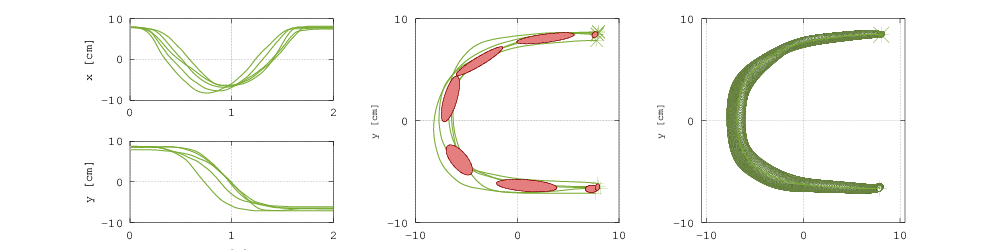

In [ ]:
figure('position',[0 0 1000 250])

%% show demonstrations
for i=1:demoNum  
    subplot(2,3,1)
    hold on
    plot([demo_dt:demo_dt:demo_dura],Data(2,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
    box on
    ylabel('x [cm]','interpreter','tex');
    set(gca,'xtick',[0 1 2])
    set(gca,'ytick',[-10 0 10])
    set(gca,'FontSize',12)
    grid on
    set(gca,'gridlinestyle','--')

    subplot(2,3,4)
    hold on
    plot([demo_dt:demo_dt:demo_dura],Data(3,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
    box on
    xlabel('t [s]','interpreter','tex');
    ylabel('y [cm]','interpreter','tex');
    set(gca,'xtick',[0 1 2])
    set(gca,'ytick',[-10 0 10])
    set(gca,'FontSize',12)
    grid on
    set(gca,'gridlinestyle','--')
end

%% show GMM
subplot(2,3,[2 5])
for i=1:demoNum
hold on
plot(Data(2,(i-1)*demoLen+1:i*demoLen),Data(3,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
end
hold on
for i=1:demoLen:demoLen*demoNum
hold on
plot(Data(2,i),Data(3,i),'*','markersize',12,'color',mycolors.g); 
end
for i=demoLen:demoLen:demoLen*demoNum
hold on
plot(Data(2,i),Data(3,i),'+','markersize',12,'color',mycolors.g); 
end
hold on
plotGMM(model.Mu(2:3,:), model.Sigma(2:3,2:3,:), [.8 0 0], .5);
box on
grid on
set(gca,'gridlinestyle','--')
xlabel('x [cm]','interpreter','tex');
ylabel('y [cm]','interpreter','tex');
set(gca,'xtick',[-10 0 10])
set(gca,'ytick',[-10 0 10])
set(gca,'FontSize',12)

%% show reference trajectory
subplot(2,3,[3 6])
hold on
plotGMM(DataOut(1:2,:), SigmaOut(1:2,1:2,:), mycolors.g, .025);
hold on
plot(DataOut(1,:),DataOut(2,:),'color',mycolors.g,'linewidth',3.0);
hold on
plot(DataOut(1,1),DataOut(2,1),'*','markersize',15,'color',mycolors.g)
hold on
plot(DataOut(1,end),DataOut(2,end),'+','markersize',15,'color',mycolors.g)
box on
xlim([-10.5 10.5])
xlabel('x [cm]','interpreter','tex');
ylabel('y [cm]','interpreter','tex');
set(gca,'xtick',[-10 0 10])
set(gca,'ytick',[-10 0 10])
set(gca,'FontSize',12)
grid on
set(gca,'gridlinestyle','--')

## Show KMP predictions

### 2-D view

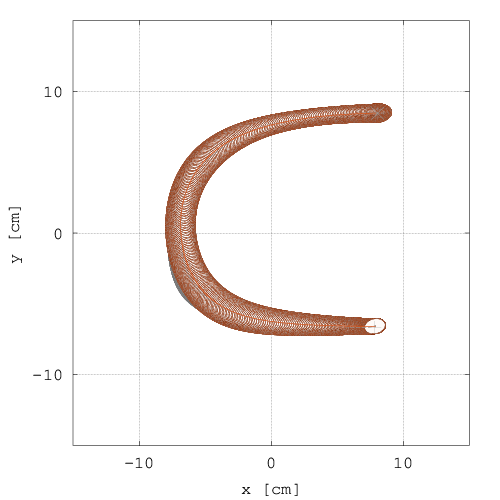

In [ ]:
figure('position',[0 0 500 500])

value=[0.5 0 0.5]; 
curveValue=mycolors.o; 

%% plot px-py
plotGMM(gmr(1:2,:), SigmaOut_gmr(1:2,1:2,:), mycolors.gy, .01);
hold on
plotGMM(kmp(1:2,:), SigmaOut_kmp(1:2,1:2,:), curveValue, .03);
hold on
plot(gmr(1,:),gmr(2,:),'--','color',mycolors.gy,'linewidth',1.5);
hold on
plot(kmp(1,:),kmp(2,:),'color',curveValue,'linewidth',2);
hold on
plot(gmr(1,1),gmr(2,1),'*','markersize',12,'color',mycolors.gy);
hold on
plot(gmr(1,end),gmr(2,end),'+','markersize',12,'color',mycolors.gy);

for viaIndex=1:viaNum
    if viaFlag(viaIndex)==1   
         plot(via_point(1,viaIndex),via_point(2,viaIndex),'o','color',value,'markersize',12,'linewidth',1.5); 
    end
end


box on
xlim([-15 15])
ylim([-15 15])
xlabel('x [cm]','interpreter','latex','fontsize',17);
ylabel('y [cm]','interpreter','latex','fontsize',17);
set(gca,'xtick',[-10 0 10]);
set(gca,'ytick',[-10 0 10]);
set(gca,'FontSize',17)
grid on
set(gca,'gridlinestyle','--')
gca;

### Output vs. time

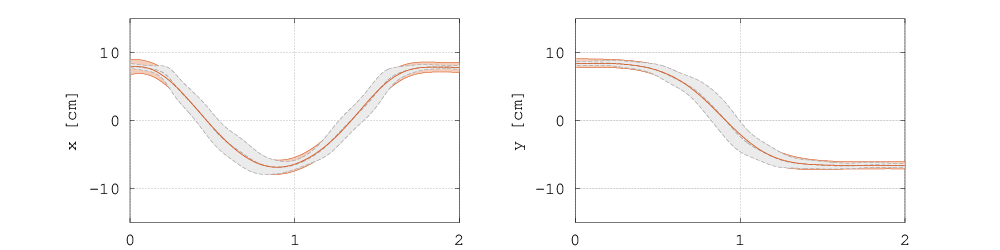

In [ ]:
figure('position',[0 0 1000 250])

%% plot t-px and t-py
shadowT=dt:dt:dt*len;
shadow_time=[shadowT,fliplr(shadowT)];

for plotIndex=1:2
    subplot(1,2,plotIndex)

    shadowUpGmr=gmr(plotIndex,:)+gmrVar(plotIndex,:);
    shadowLowGmr=gmr(plotIndex,:)-gmrVar(plotIndex,:);
    shadow_gmr=[shadowUpGmr,fliplr(shadowLowGmr)];
    shadowUpKmp=kmp(plotIndex,:)+kmpVar(plotIndex,:);
    shadowLowKmp=kmp(plotIndex,:)-kmpVar(plotIndex,:);
    shadow_kmp=[shadowUpKmp,fliplr(shadowLowKmp)];

    fill(shadow_time,shadow_kmp,curveValue,'facealpha',.3,'edgecolor','none')
    hold on
    fill(shadow_time,shadow_gmr,mycolors.gy,'facealpha',.2,'edgecolor','none')
    hold on
    plot([dt:dt:dt*len],gmr(plotIndex,:),'--','color',mycolors.gy,'linewidth',1.5)
    hold on
    plot([dt:dt:dt*len],kmp(plotIndex,:),'color',curveValue,'linewidth',2.0)

    for viaIndex=1:viaNum
        if viaFlag(viaIndex)==1   
             plot(via_time(viaIndex),via_point(plotIndex,viaIndex),'o','color',value,'markersize',12,'linewidth',1.5); 
        end
    end

    box on
    xlim([0 len*dt])
    if plotIndex==1 || plotIndex==2 
        if plotIndex==1
           ylabel('x [cm]','fontsize',17);
        end
        if plotIndex==2
           ylabel('y [cm]','fontsize',17);
        end  
        ylim([-15 15])
        set(gca,'ytick',[-10 0 10]);
    end

    xlabel('t [s]','fontsize',17);
    set(gca,'xtick',[0 1 2]);
    set(gca,'FontSize',17)
    set(gca,'FontSize',17)
    grid on
    set(gca,'gridlinestyle','--')
    gca;
end